# **Práctica Deep Learning: Redes recurrentes**

# Parte 2 - RNN

## Carlos Blom-Dahl Ramos y Daniel Lillo Plaza


# Laboratorio

Vamos a hacer predicción del valor de un activo financiero de una empresa a partir del valor de los días anteriores de varias compañías.

In [ ]:
# Importamos librerías
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv1D, LSTM, GRU
import numpy as np


In [ ]:
# Damos permiso para acceder al drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Para leer datos lo mejor es usar la toolbox pandas

Los datos se han sacado de:
https://www.kaggle.com/borismarjanovic/price-volume-data-for-all-us-stocks-etfs/version/3

In [ ]:
# Leemos los datos
import pandas as pd

dd_googl = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Deep_Learning/Recurrentes/Examples/data/googl.us.txt", delimiter=",")
dd_aa = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Deep_Learning/Recurrentes/Examples/data/aa.us.txt", delimiter=",")
dd_iae = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Deep_Learning/Recurrentes/Examples/data/iae.us.txt", delimiter=",")


In [ ]:
# Asignamos los datos a las variables

googl_op = dd_googl['Open'].values
aa_op = dd_aa['Open'].values
iae_op = dd_iae['Open'].values

In [ ]:
# Organizamos las fechas para tenerlo todo en días

aa = dd_googl['Date'].values
googl_indice = np.zeros(aa.shape)
for n in range(0, aa.shape[0]):
    cc = aa[n]
    qq1 = np.asarray(cc[0:4], dtype=np.float64, order='C')
    qq2 = np.asarray(cc[5:7], dtype=np.float64, order='C')
    qq3 = np.asarray(cc[8:10], dtype=np.float64, order='C')

    googl_indice[n] = (qq1-2000)*365 + qq2*30 + qq3

In [ ]:
# Organizamos las fechas para tenerlo todo en días

aa = dd_aa['Date'].values
aa_indice = np.zeros(aa.shape)
for n in range(0, aa.shape[0]):
    cc = aa[n]
    qq1 = np.asarray(cc[0:4], dtype=np.float64, order='C')
    qq2 = np.asarray(cc[5:7], dtype=np.float64, order='C')
    qq3 = np.asarray(cc[8:10], dtype=np.float64, order='C')

    aa_indice[n] = (qq1-2000)*365 + qq2*30 + qq3

In [ ]:
# Organizamos las fechas para tenerlo todo en días

aa = dd_iae['Date'].values
iae_indice = np.zeros(aa.shape)
for n in range(0, aa.shape[0]):
    cc = aa[n]
    qq1 = np.asarray(cc[0:4], dtype=np.float64, order='C')
    qq2 = np.asarray(cc[5:7], dtype=np.float64, order='C')
    qq3 = np.asarray(cc[8:10], dtype=np.float64, order='C')

    iae_indice[n] = (qq1-2000)*365 + qq2*30 + qq3

In [ ]:
# Comprobamos que los tamaños de valores de apertura y fechas coinciden

print(googl_indice.shape)
print(googl_op.shape)

(3333,)
(3333,)


In [ ]:
# Nos quedamos con las mismas fechas en los tres conjuntos de datos

indices = set(googl_indice) & set(aa_indice) & set(iae_indice) 

ii = np.in1d(googl_indice,list(indices))
data_googl = googl_op[ii]
ii = np.in1d(aa_indice,list(indices))
data_aa = aa_op[ii]
ii = np.in1d(iae_indice,list(indices))
data_iae = iae_op[ii]

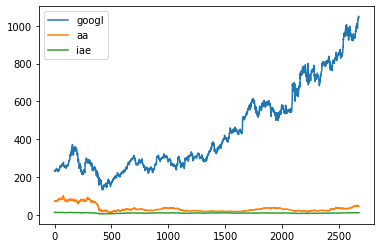

In [ ]:
# Graficamos los datos

import matplotlib.pyplot as plt
%matplotlib inline
plt.figure()
plt.plot(data_googl,label='googl')
plt.plot(data_aa,label='aa')
plt.plot(data_iae,label='iae')
plt.legend()

In [ ]:
# Juntamos los tres conjuntos de datos, por columnas, en un array 

DAT = np.zeros((data_googl.shape[0],3))
DAT[:,0] = data_googl
DAT[:,1] = data_aa
DAT[:,2] = data_iae
               

In [ ]:
# Vemos las dimensiones de nuestro array

DAT.shape

(2678, 3)

In [ ]:
# Creamos un array tridimensional llamado DAT_TS que contiene segmentos de LAG filas de DAT para cada fila de DAT (excepto las últimas LAG filas),
# es decir, una serie temporal en la que cada fila es una instantánea de LAG momentos consecutivos.

LAG = 5
DAT_TS = np.zeros((DAT.shape[0]-LAG,LAG,DAT.shape[1]))

for ii in range(0,DAT.shape[0]-LAG):
    DAT_TS[ii,:,:] = DAT[ii:ii+LAG,:]
    

In [ ]:
# Revisamos las dimensiones

DAT_TS.shape

(2673, 5, 3)

In [ ]:
# Dividimos en train y test (mitad train y mitad test)

Ntr = np.floor(DAT_TS.shape[0]/2)
Y_target = 0 # Establecemos que la que queremos predecir es Google

XX_tr = DAT_TS[range(0,int(Ntr)),0:LAG-1,:] # Dejamos el LAG 5 fuera porque emplearemos 4 datos (de tres empresas) para predecir el quinto (de la tercera empresa solamente)
XX_ts = DAT_TS[range(int(Ntr)+1,2*int(Ntr)),0:LAG-1,:]

YY_tr = DAT_TS[range(0,int(Ntr)),LAG-1,Y_target]
YY_ts = DAT_TS[range(int(Ntr)+1,2*int(Ntr)),LAG-1,Y_target]



In [ ]:
# Revisamos las dimensiones

print(XX_tr.shape)
print(XX_ts.shape)

(1336, 4, 3)
(1335, 4, 3)


## MODEL 1

In [ ]:
# Creamos el modelo 1, que se compone de una capa LSTM con una neurona, una capa de aplanamiento y una capa completamente conectada de una neurona.

model1 = Sequential()
model1.add(LSTM(1, input_shape=(XX_tr.shape[1],XX_tr.shape[2]),return_sequences=True))
model1.add(Flatten())
model1.add(Dense(1))

# Establecemos el optimizador y la función de pérdida a emplear
model1.compile(optimizer='adam',loss='mae')

In [ ]:
# Revisamos que el modelo está correctamente definido

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 4, 1)              20        
                                                                 
 flatten (Flatten)           (None, 4)                 0         
                                                                 
 dense (Dense)               (None, 1)                 5         
                                                                 
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________


## MODELO 2

In [ ]:
# Creamos el modelo 2, que se compone de una capa LSTM con diez neuronas seguida de otra capa LSTM de 10 neuronas y una capa completamente conectada de una neurona.

model2 = Sequential()
model2.add(LSTM(10, input_shape=(XX_tr.shape[1],XX_tr.shape[2]), return_sequences = True))
model2.add(LSTM(10))
model2.add(Dense(1))

# Establecemos el optimizador y la función de pérdida a emplear
model2.compile(optimizer='adam',loss='mae')

In [ ]:
# Revisamos que el modelo está correctamente definido

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 4, 10)             560       
                                                                 
 lstm_2 (LSTM)               (None, 10)                840       
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 1,411
Trainable params: 1,411
Non-trainable params: 0
_________________________________________________________________


## MODELO 3

In [ ]:
# Creamos el modelo 3, que se compone de una capa LSTM con diez neuronas, seguida de una capa GRU de 10 neuronas y activación lineal y una capa completamente conectada de una neurona.

model3 = Sequential()
model3.add(LSTM(10, input_shape=(XX_tr.shape[1],XX_tr.shape[2],), return_sequences = True,activation="linear"))
model3.add(GRU(10,activation="linear"))
model3.add(Dense(1))

# Establecemos el optimizador y la función de pérdida a emplear
model3.compile(optimizer='adam',loss='mae')

In [ ]:
# Revisamos que el modelo está correctamente definido

model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 4, 10)             560       
                                                                 
 gru (GRU)                   (None, 10)                660       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 1,231
Trainable params: 1,231
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Entrenamos el tercer modelo

from keras.callbacks import History 
history = History()

model3.fit(XX_tr, YY_tr, batch_size=32, epochs=50, verbose=1, callbacks=[history])

Epoch 1/50
42/42 [==============================] - 8s 24ms/step - loss: 168.2037
Epoch 2/50
42/42 [==============================] - 2s 56ms/step - loss: 15.6140
Epoch 3/50
42/42 [==============================] - 1s 32ms/step - loss: 6.6567
Epoch 4/50
42/42 [==============================] - 1s 19ms/step - loss: 5.7614
Epoch 5/50
42/42 [==============================] - 1s 18ms/step - loss: 5.8904
Epoch 6/50
42/42 [==============================] - 1s 19ms/step - loss: 5.0207
Epoch 7/50
42/42 [==============================] - 1s 19ms/step - loss: 4.7825
Epoch 8/50
42/42 [==============================] - 1s 19ms/step - loss: 4.6294
Epoch 9/50
42/42 [==============================] - 1s 19ms/step - loss: 4.5362
Epoch 10/50
42/42 [==============================] - 1s 18ms/step - loss: 4.4329
Epoch 11/50
42/42 [==============================] - 1s 19ms/step - loss: 4.3488
Epoch 12/50
42/42 [==============================] - 1s 19ms/step - loss: 4.3099
Epoch 13/50
42/42 [===============

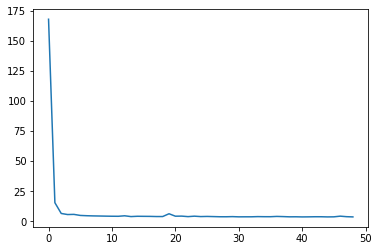

In [ ]:
# Evaluamos los resultados del entrenamiento mediante el comportamiento de la función de pérdida

loss_ev = history.history['loss']

import matplotlib.pyplot as plt
%matplotlib inline
plt.figure()
plt.plot(loss_ev[0:-1])

In [ ]:
# Evaluamos el tercer modelo mediante su score

score = model3.evaluate(XX_tr, YY_tr, verbose=0)
score

4.133862018585205

In [ ]:
# Realizamos las predicciones y calculamos el MAE (en el train)

y_hat = model3.predict(XX_tr)
np.mean(abs(y_hat[:,0]-YY_tr))

42/42 [==============================] - 0s 3ms/step


4.133862022354217

In [ ]:
# Revisamos las dimensiones

y_hat.shape

(1336, 1)

## TEST

In [ ]:
# Hacemos predicciones y calculamos el MAE en el grupo test

y_hat = model3.predict(XX_ts)
np.mean(abs(y_hat[:,0]-YY_ts))

42/42 [==============================] - 0s 4ms/step


9.132818455385358

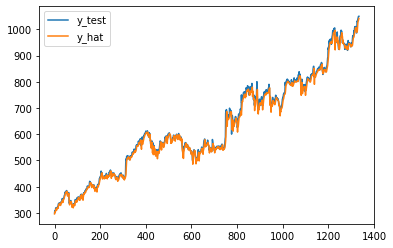

In [ ]:
# Graficamos los resultados obtenidos

%matplotlib inline
plt.figure()
plt.plot(YY_ts, label='y_test')
plt.plot(y_hat,label='y_hat')
plt.legend()

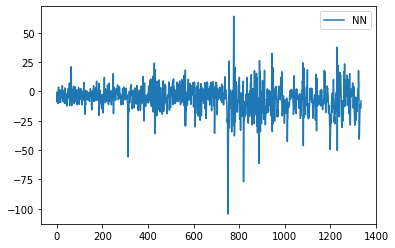

In [ ]:
# Graficamo el error (recordemos que no está normalizado)

import matplotlib.pyplot as plt
%matplotlib inline
plt.figure()
plt.plot(y_hat[:,0]-YY_ts, label='NN')
plt.legend()

# Ejercicios

1) Comenta cada celda del código

2) Crea, entrena y prueba un modelo con capas recurrentes y convolucionales. Da el valor de `mae` en entrenamiento y test. 


3) Modifica la capa LSTM para que use una función de activación diferente. ¿Qué pasa con el entrenamiento?


4) Haz un modelo que use la capa Bidirectional:
https://keras.io/api/layers/recurrent_layers/bidirectional/

EXTRA 1) Tutorial para implementar RNN sequence-to-sequence en keras.

https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html

EXTRA 2) Tutorial para ver como funciona un Chatbot implementado con RNN

https://colab.research.google.com/github/pytorch/tutorials/blob/gh-pages/_downloads/chatbot_tutorial.ipynb#scrollTo=uy7AvYeYxdk7

-------------------

In [ ]:
# Creamos un modelo con capas recurrentes y convolucionales

model4 = Sequential()
model4.add(Conv1D(10, 3,input_shape=(XX_tr.shape[1],XX_tr.shape[2],)))
model4.add(LSTM(10, input_shape=(XX_tr.shape[1],XX_tr.shape[2],), return_sequences=True, activation="linear"))
model4.add(Flatten())
model4.add(Dense(1))

# Establecemos el optimizador y la función de pérdida a emplear
model4.compile(optimizer='adam', loss='mae')

In [ ]:
# Revisamos que el modelo está correctamente definido

model4.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 2, 10)             100       
                                                                 
 lstm_5 (LSTM)               (None, 2, 10)             840       
                                                                 
 flatten_1 (Flatten)         (None, 20)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 21        
                                                                 
Total params: 961
Trainable params: 961
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Entrenamos el cuarto modelo

from keras.callbacks import History 
history = History()

model4.fit(XX_tr, YY_tr, batch_size=32, epochs=50, verbose=1, callbacks=[history])

Epoch 1/50
42/42 [==============================] - 2s 7ms/step - loss: 259.8358
Epoch 2/50
42/42 [==============================] - 0s 8ms/step - loss: 220.9082
Epoch 3/50
42/42 [==============================] - 0s 7ms/step - loss: 90.0380
Epoch 4/50
42/42 [==============================] - 0s 7ms/step - loss: 8.9089
Epoch 5/50
42/42 [==============================] - 0s 7ms/step - loss: 6.5359
Epoch 6/50
42/42 [==============================] - 0s 7ms/step - loss: 6.1280
Epoch 7/50
42/42 [==============================] - 0s 7ms/step - loss: 6.0568
Epoch 8/50
42/42 [==============================] - 0s 8ms/step - loss: 5.9469
Epoch 9/50
42/42 [==============================] - 0s 7ms/step - loss: 5.9561
Epoch 10/50
42/42 [==============================] - 0s 7ms/step - loss: 6.2317
Epoch 11/50
42/42 [==============================] - 0s 7ms/step - loss: 5.9727
Epoch 12/50
42/42 [==============================] - 0s 8ms/step - loss: 5.8990
Epoch 13/50
42/42 [=========================

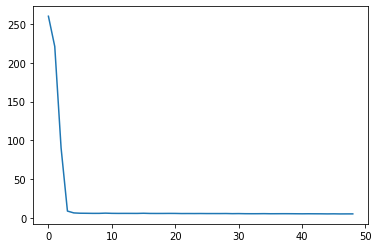

In [ ]:
# Evaluamos los resultados del entrenamiento mediante el comportamiento de la función de pérdida

loss_ev = history.history['loss']

import matplotlib.pyplot as plt
%matplotlib inline
plt.figure()
plt.plot(loss_ev[0:-1])

In [ ]:
# Evaluamos el cuarto modelo mediante su score

score = model4.evaluate(XX_tr, YY_tr, verbose=0)
score

5.16161584854126

In [ ]:
# Realizamos las predicciones y calculamos el MAE (en el train)

y_hat = model4.predict(XX_tr)
np.mean(abs(y_hat[:,0]-YY_tr))

42/42 [==============================] - 0s 2ms/step


5.161615363480801

In [ ]:
# Hacemos predicciones y calculamos el MAE en el grupo test

y_hat = model4.predict(XX_ts)
np.mean(abs(y_hat[:,0]-YY_ts))

42/42 [==============================] - 0s 2ms/step


8.64841832078798

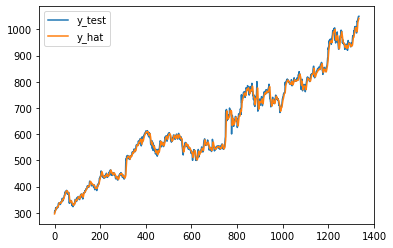

In [ ]:
# Graficamos los resultados obtenidos

%matplotlib inline
plt.figure()
plt.plot(YY_ts, label='y_test')
plt.plot(y_hat,label='y_hat')
plt.legend()

In [ ]:
# Vamos a cambiar la activación de la capa LSTM

model4 = Sequential()
model4.add(Conv1D(10, 3,input_shape=(XX_tr.shape[1],XX_tr.shape[2],)))
model4.add(LSTM(10, input_shape=(XX_tr.shape[1],XX_tr.shape[2],), return_sequences=True, activation="sigmoid"))
model4.add(Flatten())
model4.add(Dense(1))

# Establecemos el optimizador y la función de pérdida a emplear
model4.compile(optimizer='adam', loss='mae')

In [ ]:
# Revisamos que el modelo está correctamente definido

model4.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 2, 10)             100       
                                                                 
 lstm_8 (LSTM)               (None, 2, 10)             840       
                                                                 
 flatten_4 (Flatten)         (None, 20)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                 21        
                                                                 
Total params: 961
Trainable params: 961
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Entrenamos el cuarto modelo modificado

from keras.callbacks import History 
history = History()

model4.fit(XX_tr, YY_tr, batch_size=32, epochs=50, verbose=1, callbacks=[history])

Epoch 1/50
42/42 [==============================] - 2s 8ms/step - loss: 260.4968
Epoch 2/50
42/42 [==============================] - 0s 8ms/step - loss: 260.0747
Epoch 3/50
42/42 [==============================] - 0s 7ms/step - loss: 259.7290
Epoch 4/50
42/42 [==============================] - 0s 7ms/step - loss: 259.4390
Epoch 5/50
42/42 [==============================] - 0s 8ms/step - loss: 259.1590
Epoch 6/50
42/42 [==============================] - 0s 7ms/step - loss: 258.8841
Epoch 7/50
42/42 [==============================] - 0s 7ms/step - loss: 258.6121
Epoch 8/50
42/42 [==============================] - 0s 7ms/step - loss: 258.3421
Epoch 9/50
42/42 [==============================] - 0s 7ms/step - loss: 258.0735
Epoch 10/50
42/42 [==============================] - 0s 7ms/step - loss: 257.8058
Epoch 11/50
42/42 [==============================] - 0s 9ms/step - loss: 257.5390
Epoch 12/50
42/42 [==============================] - 0s 10ms/step - loss: 257.2729
Epoch 13/50
42/42 [=====

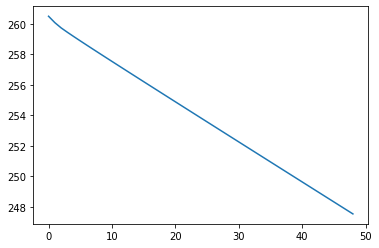

In [ ]:
# Evaluamos los resultados del entrenamiento mediante el comportamiento de la función de pérdida

loss_ev = history.history['loss']

import matplotlib.pyplot as plt
%matplotlib inline
plt.figure()
plt.plot(loss_ev[0:-1])

In [ ]:
# Evaluamos el cuarto modelo mediante su score

score = model4.evaluate(XX_tr, YY_tr, verbose=0)
score

247.15208435058594

In [ ]:
# Realizamos las predicciones y calculamos el MAE (en el train)

y_hat = model4.predict(XX_tr)
np.mean(abs(y_hat[:,0]-YY_tr))

42/42 [==============================] - 0s 2ms/step


247.15209902689128

In [ ]:
# Hacemos predicciones y calculamos el MAE en el grupo test

y_hat = model4.predict(XX_ts)
np.mean(abs(y_hat[:,0]-YY_ts))

42/42 [==============================] - 0s 2ms/step


616.1405323063997

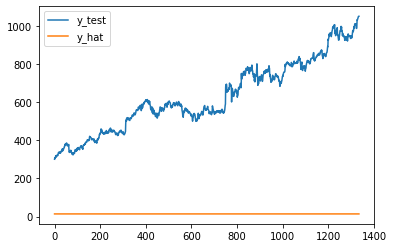

In [ ]:
# Graficamos los resultados obtenidos

%matplotlib inline
plt.figure()
plt.plot(YY_ts, label='y_test')
plt.plot(y_hat,label='y_hat')
plt.legend()

Vemos cómo los resultados empeoran notablemente. Esto puede ser debido, entre otras cosas, a que una LSTM es muy sensible a la escala de los datos, y má aún si se emplean funciones de activación _sigmoid_ o _tanh_. Por último, añadiremos una capa de tipo _Bidirectional_.

In [ ]:
from keras.layers import Bidirectional

model4 = Sequential()
model4.add(Conv1D(10, 3,input_shape=(XX_tr.shape[1],XX_tr.shape[2],)))
model4.add(Bidirectional(LSTM(10, input_shape=(XX_tr.shape[1],XX_tr.shape[2],), return_sequences=True, activation="linear")))
model4.add(Flatten())
model4.add(Dense(1))

# Establecemos el optimizador y la función de pérdida a emplear
model4.compile(optimizer='adam', loss='mae')




In [ ]:
# Revisamos que el modelo está correctamente definido

model4.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, 2, 10)             100       
                                                                 
 bidirectional (Bidirectiona  (None, 2, 20)            1680      
 l)                                                              
                                                                 
 flatten_5 (Flatten)         (None, 40)                0         
                                                                 
 dense_8 (Dense)             (None, 1)                 41        
                                                                 
Total params: 1,821
Trainable params: 1,821
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Entrenamos el cuarto modelo con caa bidireccional

from keras.callbacks import History 
history = History()

model4.fit(XX_tr, YY_tr, batch_size=32, epochs=50, verbose=1, callbacks=[history])

Epoch 1/50
42/42 [==============================] - 4s 12ms/step - loss: 115.0311
Epoch 2/50
42/42 [==============================] - 1s 12ms/step - loss: 7.3723
Epoch 3/50
42/42 [==============================] - 1s 12ms/step - loss: 5.3161
Epoch 4/50
42/42 [==============================] - 1s 23ms/step - loss: 5.3673
Epoch 5/50
42/42 [==============================] - 1s 32ms/step - loss: 5.1317
Epoch 6/50
42/42 [==============================] - 1s 24ms/step - loss: 5.1862
Epoch 7/50
42/42 [==============================] - 1s 16ms/step - loss: 5.1786
Epoch 8/50
42/42 [==============================] - 1s 20ms/step - loss: 5.0596
Epoch 9/50
42/42 [==============================] - 1s 34ms/step - loss: 4.9607
Epoch 10/50
42/42 [==============================] - 2s 38ms/step - loss: 5.2073
Epoch 11/50
42/42 [==============================] - 2s 40ms/step - loss: 5.3561
Epoch 12/50
42/42 [==============================] - 1s 27ms/step - loss: 4.9941
Epoch 13/50
42/42 [================

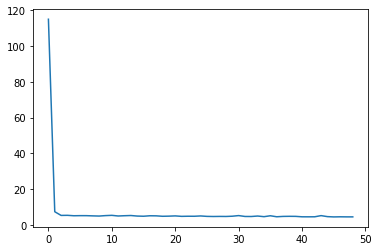

In [ ]:
# Evaluamos los resultados del entrenamiento mediante el comportamiento de la función de pérdida

loss_ev = history.history['loss']

import matplotlib.pyplot as plt
%matplotlib inline
plt.figure()
plt.plot(loss_ev[0:-1])

In [ ]:
# Evaluamos el cuarto modelo mediante su score

score = model4.evaluate(XX_tr, YY_tr, verbose=0)
score

4.414212703704834

In [ ]:
# Realizamos las predicciones y calculamos el MAE (en el train)

y_hat = model4.predict(XX_tr)
np.mean(abs(y_hat[:,0]-YY_tr))

42/42 [==============================] - 0s 2ms/step


4.4142120036964645

In [ ]:
# Hacemos predicciones y calculamos el MAE en el grupo test

y_hat = model4.predict(XX_ts)
np.mean(abs(y_hat[:,0]-YY_ts))

42/42 [==============================] - 0s 3ms/step


10.036745452766564

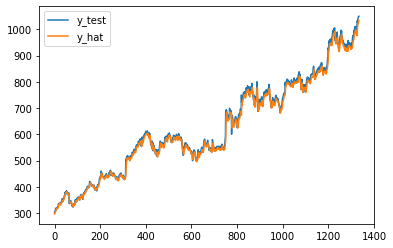

In [ ]:
# Graficamos los resultados obtenidos

%matplotlib inline
plt.figure()
plt.plot(YY_ts, label='y_test')
plt.plot(y_hat,label='y_hat')
plt.legend()